In [1]:
import os
import matplotlib.pyplot as plt
from keras.applications import xception
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import cv2
from tqdm import tqdm
from keras.models import Model, Sequential
from keras.layers import Activation, Dense
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

- DATA UTILITIES

In [2]:
#copying the pretrained models to the cache directory
cache_dir = os.path.expanduser(os.path.join('~', '.keras'))
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
models_dir = os.path.join(cache_dir, 'models')
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

#copy the Xception models
# !cp ../input/keras-pretrained-models/xception* ~/.keras/models/
#show
!ls ~/.keras/models


xception_weights_tf_dim_ordering_tf_kernels.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


In [3]:
data_folder = './archive/'
categories = ['with_mask', 'without_mask']
len_categories = len(categories)
print('Mask Categories:', len_categories)

Mask Categories: 2


- CREATE A DATAFRAME

In [4]:
#show number of images per category
for category in categories:
    filenames = os.listdir(os.path.join(data_folder, category))
    print('{} {} images'.format(category, len(filenames)))

with_mask 1915 images
without_mask 1918 images


In [5]:
train_data = []

for i, category in tqdm(enumerate(categories)):
    class_folder = os.path.join(data_folder, category)    
    for path in os.listdir(os.path.join(class_folder)):
        train_data.append(['{}/{}'.format(category, path), category, i])
df = pd.DataFrame(train_data, columns=['filepath', 'class', 'label'])

#reduce the data
SAMPLE_PER_CATEGORY = 500
df = pd.concat([df[df['class'] == i][:SAMPLE_PER_CATEGORY] for i in categories])

2it [00:00, 269.88it/s]


In [6]:
df.head()

,filepath,class,label
0,"with_mask/image1,000.jpg",with_mask,0
1,"with_mask/image1,001.jpg",with_mask,0
2,"with_mask/image1,002.jpg",with_mask,0
3,"with_mask/image1,003.jpg",with_mask,0
4,"with_mask/image1,004.jpg",with_mask,0


- SHOW SAMPLE IMAGES

In [7]:
# function to get an image
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_folder, filepath), target_size=size)
    #convert image to array
    img = image.img_to_array(img)
    return img

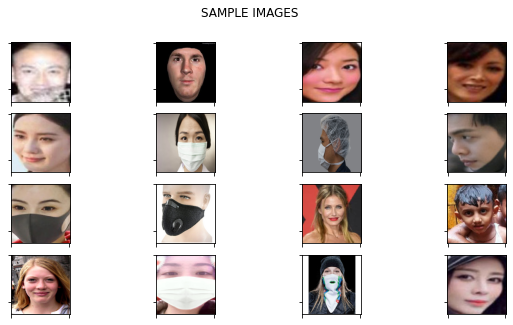

In [8]:
nb_rows = 4
nb_cols = 4
fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 5));
plt.suptitle('SAMPLE IMAGES')
for i in range(0, nb_rows):
    for j in range(0, nb_cols):
        axs[i, j].xaxis.set_ticklabels([])
        axs[i, j].yaxis.set_ticklabels([])
        axs[i, j].imshow((read_img(df['filepath'].iloc[np.random.randint(998)], (255,255)))/255)
plt.show()

- PREPROCESSING THE IMAGES
    - First, we blur the image. We know by smoothing an image we suppress most of the high-frequency components.
    - Then, we subtract this smoothed image from the original image(the resulting difference is known as a mask). Thus, the output image will have most of the high-frequency components that are blocked by the smoothing filter.
    - Adding this mask back to the original will enhance the high-frequency components.


In [9]:
def understand_gaussianblur(src_image):
    # read image
    image = cv2.imread(src_image)
    # apply guassian blur on src image
    image_blurred = cv2.GaussianBlur(image,(0, 0),3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    # display input and output image
    cv2.imshow("Gaussian + addWeighted",np.hstack((image,image_blurred, image_sharp)))
    cv2.waitKey(0) # waits until a key is pressed
    cv2.destroyAllWindows() # destroys the window showing image
    
# understand_gaussianblur('archive/without_mask/Faceimg1,093.jpg')
# understand_gaussianblur('archive/with_mask/image994.jpg')

In [10]:
# function to sharpen the images(图像锐化算法)
def sharpen_image(image):
    # 高斯滤波是一种线性平滑滤波，适用于消除高斯噪声，广泛应用于图像处理的减噪过程。
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    # addWeighted()函数是将两张相同大小，相同类型的图片（叠加）线性融合的函数，可以实现图片的特效。
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp / 255

In [11]:
INPUT_SIZE = 255
X_train = np.zeros((len(df), INPUT_SIZE, INPUT_SIZE, 3), dtype='float')

for i, file in tqdm(enumerate(df['filepath'])):
    img_sharpen = sharpen_image(read_img(file, (255,255)))
    X_train[i] = xception.preprocess_input(np.expand_dims(img_sharpen.copy(), axis=0))

1000it [00:09, 100.88it/s]


In [12]:
print('Train Image Shape: ', X_train.shape)
print('Train Image Size: ', X_train.size)

Train Image Shape:  (1000, 255, 255, 3)
Train Image Size:  195075000


When  evaluate the predictive performance of  model, its essential that the process be unbiased. Using train_test_split() from the data science library scikit-learn, We can split our dataset into subsets that minimize the potential for bias in  evaluation and validation process.Here 80% of images were assigned for training and 20% for validating the ML models.

In [13]:
#split the data
y = df['label']
train_x, train_val, y_train, y_val = train_test_split(X_train, y, test_size=0.2, random_state=101)

In [14]:
print("all count:",X_train.shape[0])
print("train count:", train_x.shape[0])
print('test count:', train_val.shape[0])

all count: 1000
train count: 800
test count: 200


- BOTTLENECK FEATURE EXTRACTION


    - weights：None代表随机初始化，即不加载预训练权重。'imagenet’代表加载预训练权重
    - include_top：是否保留顶层的3个全连接网络
    - pooling='avg':平均池化


In [15]:
xception_bf = xception.Xception(weights='imagenet', include_top=False, pooling='avg')
bf_train_x = xception_bf.predict(train_x, batch_size=32, verbose=1)
bf_train_val = xception_bf.predict(train_val, batch_size=32, verbose=1)

7/7 [==============================] - 20s 3s/step


In [16]:
#print shape of feature and size
print('Train Shape: ', bf_train_x.shape)
print('Train Size: ', bf_train_x.size)

print('Validation Shape: ', bf_train_val.shape)
print('Validation Size: ', bf_train_val.size)

Train Shape:  (800, 2048)
Train Size:  1638400
Validation Shape:  (200, 2048)
Validation Size:  409600


- MODELLING

The model consists of three convolution blocks with a average pool layer in each of them. There's not have fully connected layer with 256 units on top of it that is activated by a relu activation function and sigmod activation function. This model has not been tuned for high accuracy, the goal of this tutorial is to show a standard approach.

In [17]:
#optimizer
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

#keras model
model = Sequential()
model.add(Dense(units = 256 , activation = 'relu', input_dim=bf_train_x.shape[1]))
model.add(Dense(units = 64 , activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = opt,loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 541,057
Trainable params: 541,057
Non-trainable params: 0
_________________________________________________________________


In [18]:
#set callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
         ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

#fit the data
history = model.fit(bf_train_x, y_train, batch_size=32, epochs=500,  callbacks=callbacks)

Epoch 1/500
25/25 [==============================] - 0s 2ms/step - loss: 0.6872 - accuracy: 0.5308
Epoch 2/500
25/25 [==============================] - 0s 2ms/step - loss: 0.6685 - accuracy: 0.5379
Epoch 3/500
25/25 [==============================] - 0s 2ms/step - loss: 0.6523 - accuracy: 0.6095
Epoch 4/500
25/25 [==============================] - 0s 2ms/step - loss: 0.6170 - accuracy: 0.6407
Epoch 5/500
25/25 [==============================] - 0s 2ms/step - loss: 0.5919 - accuracy: 0.6687
Epoch 6/500
25/25 [==============================] - 0s 3ms/step - loss: 0.5405 - accuracy: 0.7433
Epoch 7/500
25/25 [==============================] - 0s 3ms/step - loss: 0.5338 - accuracy: 0.7194
Epoch 8/500
25/25 [==============================] - 0s 2ms/step - loss: 0.5033 - accuracy: 0.7052
Epoch 9/500
25/25 [==============================] - 0s 3ms/step - loss: 0.4602 - accuracy: 0.7847
Epoch 10/500
25/25 [==============================] - 0s 2ms/step - loss: 0.4695 - accuracy: 0.7812
Epoch 11/

Epoch 28/500
25/25 [==============================] - 0s 2ms/step - loss: 0.2742 - accuracy: 0.8907
Epoch 29/500
25/25 [==============================] - 0s 2ms/step - loss: 0.2821 - accuracy: 0.8942
Epoch 30/500
25/25 [==============================] - 0s 2ms/step - loss: 0.3416 - accuracy: 0.8464
Epoch 31/500
25/25 [==============================] - 0s 2ms/step - loss: 0.2733 - accuracy: 0.8809
Epoch 32/500
25/25 [==============================] - 0s 2ms/step - loss: 0.3697 - accuracy: 0.8141
Epoch 33/500
25/25 [==============================] - 0s 2ms/step - loss: 0.2633 - accuracy: 0.8824
Epoch 34/500
25/25 [==============================] - 0s 5ms/step - loss: 0.3125 - accuracy: 0.8536
Epoch 35/500
25/25 [==============================] - 0s 3ms/step - loss: 0.2639 - accuracy: 0.8936
Epoch 36/500
25/25 [==============================] - 0s 2ms/step - loss: 0.2961 - accuracy: 0.8790
Epoch 37/500
25/25 [==============================] - 0s 2ms/step - loss: 0.2415 - accuracy: 0.9064


Epoch 55/500
25/25 [==============================] - 0s 2ms/step - loss: 0.3511 - accuracy: 0.8373
Epoch 56/500
25/25 [==============================] - 0s 2ms/step - loss: 0.2317 - accuracy: 0.8986
Epoch 57/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1745 - accuracy: 0.9196
Epoch 58/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1793 - accuracy: 0.9163
Epoch 59/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1871 - accuracy: 0.9176
Epoch 60/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1919 - accuracy: 0.9191
Epoch 61/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1641 - accuracy: 0.9353
Epoch 62/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1839 - accuracy: 0.9223
Epoch 63/500
25/25 [==============================] - 0s 2ms/step - loss: 0.2458 - accuracy: 0.9043
Epoch 64/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1515 - accuracy: 0.9378


Epoch 82/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1563 - accuracy: 0.9338
Epoch 83/500
25/25 [==============================] - 0s 2ms/step - loss: 0.2277 - accuracy: 0.9049
Epoch 84/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1740 - accuracy: 0.9315
Epoch 85/500
25/25 [==============================] - 0s 2ms/step - loss: 0.2139 - accuracy: 0.9065
Epoch 86/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1674 - accuracy: 0.9291
Epoch 87/500
25/25 [==============================] - 0s 2ms/step - loss: 0.2388 - accuracy: 0.9088
Epoch 88/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1328 - accuracy: 0.9639
Epoch 89/500
25/25 [==============================] - 0s 2ms/step - loss: 0.2327 - accuracy: 0.9012
Epoch 90/500
25/25 [==============================] - 0s 2ms/step - loss: 0.2277 - accuracy: 0.8991
Epoch 91/500
25/25 [==============================] - 0s 2ms/step - loss: 0.2777 - accuracy: 0.8638


Epoch 109/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1980 - accuracy: 0.9144
Epoch 110/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1442 - accuracy: 0.9421
Epoch 111/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1447 - accuracy: 0.9468
Epoch 112/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1185 - accuracy: 0.9590
Epoch 113/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1236 - accuracy: 0.9411
Epoch 114/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1289 - accuracy: 0.9512
Epoch 115/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1098 - accuracy: 0.9671
Epoch 116/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1158 - accuracy: 0.9651
Epoch 117/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1727 - accuracy: 0.9367
Epoch 118/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1149 - accurac

Epoch 136/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1717 - accuracy: 0.9318
Epoch 137/500
25/25 [==============================] - 0s 3ms/step - loss: 0.1421 - accuracy: 0.9479
Epoch 138/500
25/25 [==============================] - 0s 3ms/step - loss: 0.1150 - accuracy: 0.9566
Epoch 139/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1072 - accuracy: 0.9602
Epoch 140/500
25/25 [==============================] - 0s 3ms/step - loss: 0.0847 - accuracy: 0.9699
Epoch 141/500
25/25 [==============================] - 0s 3ms/step - loss: 0.1254 - accuracy: 0.9532
Epoch 142/500
25/25 [==============================] - 0s 3ms/step - loss: 0.1190 - accuracy: 0.9628
Epoch 143/500
25/25 [==============================] - 0s 3ms/step - loss: 0.0928 - accuracy: 0.9673
Epoch 144/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1489 - accuracy: 0.9407
Epoch 145/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0935 - accurac

Epoch 163/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1061 - accuracy: 0.9637
Epoch 164/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1920 - accuracy: 0.9380
Epoch 165/500
25/25 [==============================] - 0s 2ms/step - loss: 0.3035 - accuracy: 0.8733
Epoch 166/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1820 - accuracy: 0.9187
Epoch 167/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1237 - accuracy: 0.9617
Epoch 168/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1522 - accuracy: 0.9464
Epoch 169/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1901 - accuracy: 0.9377
Epoch 170/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1411 - accuracy: 0.9350
Epoch 171/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0940 - accuracy: 0.9729
Epoch 172/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0806 - accurac

Epoch 190/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0831 - accuracy: 0.9738
Epoch 191/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0792 - accuracy: 0.9742
Epoch 192/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0852 - accuracy: 0.9652
Epoch 193/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1049 - accuracy: 0.9549
Epoch 194/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0556 - accuracy: 0.9878
Epoch 195/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0996 - accuracy: 0.9661
Epoch 196/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1106 - accuracy: 0.9560
Epoch 197/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0900 - accuracy: 0.9641
Epoch 198/500
25/25 [==============================] - 0s 3ms/step - loss: 0.0689 - accuracy: 0.9669
Epoch 199/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1043 - accurac

Epoch 217/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1237 - accuracy: 0.9554
Epoch 218/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0634 - accuracy: 0.9736
Epoch 219/500
25/25 [==============================] - 0s 3ms/step - loss: 0.0998 - accuracy: 0.9574
Epoch 220/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1872 - accuracy: 0.9321
Epoch 221/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0589 - accuracy: 0.9825
Epoch 222/500
25/25 [==============================] - 0s 3ms/step - loss: 0.0713 - accuracy: 0.9750
Epoch 223/500
25/25 [==============================] - 0s 4ms/step - loss: 0.1093 - accuracy: 0.9540
Epoch 224/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1157 - accuracy: 0.9582
Epoch 225/500
25/25 [==============================] - 0s 3ms/step - loss: 0.0948 - accuracy: 0.9631
Epoch 226/500
25/25 [==============================] - 0s 3ms/step - loss: 0.0613 - accurac

Epoch 244/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0903 - accuracy: 0.9657
Epoch 245/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1215 - accuracy: 0.9652
Epoch 246/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1579 - accuracy: 0.9403
Epoch 247/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0845 - accuracy: 0.9713
Epoch 248/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0723 - accuracy: 0.9765
Epoch 249/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0730 - accuracy: 0.9754
Epoch 250/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0868 - accuracy: 0.9641
Epoch 251/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0674 - accuracy: 0.9679
Epoch 252/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0665 - accuracy: 0.9763
Epoch 253/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0605 - accurac

Epoch 271/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0929 - accuracy: 0.9687
Epoch 272/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0594 - accuracy: 0.9797
Epoch 273/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0878 - accuracy: 0.9688
Epoch 274/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0534 - accuracy: 0.9813
Epoch 275/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0609 - accuracy: 0.9742
Epoch 276/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0599 - accuracy: 0.9732
Epoch 277/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1209 - accuracy: 0.9465
Epoch 278/500
25/25 [==============================] - 0s 3ms/step - loss: 0.1671 - accuracy: 0.9270
Epoch 279/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0772 - accuracy: 0.9756
Epoch 280/500
25/25 [==============================] - 0s 3ms/step - loss: 0.0555 - accurac

Epoch 298/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0424 - accuracy: 0.9925
Epoch 299/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0514 - accuracy: 0.9775
Epoch 300/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1151 - accuracy: 0.9507
Epoch 301/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0473 - accuracy: 0.9823
Epoch 302/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0517 - accuracy: 0.9765
Epoch 303/500
25/25 [==============================] - 0s 3ms/step - loss: 0.0385 - accuracy: 0.9898
Epoch 304/500
25/25 [==============================] - 0s 3ms/step - loss: 0.0473 - accuracy: 0.9829
Epoch 305/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0436 - accuracy: 0.9805
Epoch 306/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0771 - accuracy: 0.9623
Epoch 307/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0511 - accurac

Epoch 325/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0475 - accuracy: 0.9750
Epoch 326/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0343 - accuracy: 0.9879
Epoch 327/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - accuracy: 0.9852
Epoch 328/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0560 - accuracy: 0.9838
Epoch 329/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0660 - accuracy: 0.9791
Epoch 330/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0393 - accuracy: 0.9865
Epoch 331/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0376 - accuracy: 0.9865
Epoch 332/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0372 - accuracy: 0.9875
Epoch 333/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0422 - accuracy: 0.9776
Epoch 334/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0321 - accurac

Epoch 352/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0672 - accuracy: 0.9734
Epoch 353/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0434 - accuracy: 0.9830
Epoch 354/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0560 - accuracy: 0.9729
Epoch 355/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0438 - accuracy: 0.9872
Epoch 356/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0250 - accuracy: 0.9934
Epoch 357/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0483 - accuracy: 0.9824
Epoch 358/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0558 - accuracy: 0.9690
Epoch 359/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0346 - accuracy: 0.9849
Epoch 360/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0228 - accuracy: 0.9980
Epoch 361/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0305 - accurac

Epoch 379/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0297 - accuracy: 0.9847
Epoch 380/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0343 - accuracy: 0.9861
Epoch 381/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0212 - accuracy: 0.9930
Epoch 382/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0344 - accuracy: 0.9881
Epoch 383/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0395 - accuracy: 0.9819
Epoch 384/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0215 - accuracy: 0.9917
Epoch 385/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0324 - accuracy: 0.9902
Epoch 386/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0233 - accuracy: 0.9926
Epoch 387/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0391 - accuracy: 0.9879
Epoch 388/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0266 - accurac

Epoch 406/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0445 - accuracy: 0.9856
Epoch 407/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0384 - accuracy: 0.9871
Epoch 408/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0268 - accuracy: 0.9879
Epoch 409/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0271 - accuracy: 0.9926
Epoch 410/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0419 - accuracy: 0.9864
Epoch 411/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0250 - accuracy: 0.9944
Epoch 412/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0271 - accuracy: 0.9943
Epoch 413/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0326 - accuracy: 0.9913
Epoch 414/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0211 - accuracy: 0.9963
Epoch 415/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0286 - accurac

Epoch 433/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0151 - accuracy: 0.9969
Epoch 434/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0220 - accuracy: 0.9919
Epoch 435/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0231 - accuracy: 0.9942
Epoch 436/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0672 - accuracy: 0.9689
Epoch 437/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1331 - accuracy: 0.9478
Epoch 438/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0912 - accuracy: 0.9508
Epoch 439/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0454 - accuracy: 0.9829
Epoch 440/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0284 - accuracy: 0.9891
Epoch 441/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0487 - accuracy: 0.9846
Epoch 442/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0136 - accurac

Epoch 460/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0222 - accuracy: 0.9924
Epoch 461/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0165 - accuracy: 0.9960
Epoch 462/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0195 - accuracy: 0.9953
Epoch 463/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0346 - accuracy: 0.9925
Epoch 464/500
25/25 [==============================] - 0s 3ms/step - loss: 0.2908 - accuracy: 0.9085
Epoch 465/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0533 - accuracy: 0.9799
Epoch 466/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0463 - accuracy: 0.9877
Epoch 467/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0187 - accuracy: 0.9965
Epoch 468/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0735 - accuracy: 0.9708
Epoch 469/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0172 - accurac

Epoch 487/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0952 - accuracy: 0.9683
Epoch 488/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0404 - accuracy: 0.9908
Epoch 489/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0304 - accuracy: 0.9889
Epoch 490/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0146 - accuracy: 0.9982
Epoch 491/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0126 - accuracy: 0.9995
Epoch 492/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0095 - accuracy: 0.9987
Epoch 493/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0125 - accuracy: 0.9966
Epoch 494/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0100 - accuracy: 0.9989
Epoch 495/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0200 - accuracy: 0.9971
Epoch 496/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0146 - accurac

- LOSS AND ACCURACY
    - Loss can be seen as a distance between the true values of the problem and the values predicted by the model. Greater the loss is, more huge is the errors you made on the data.
    - Accuracy can be seen as the number of error you made on the data

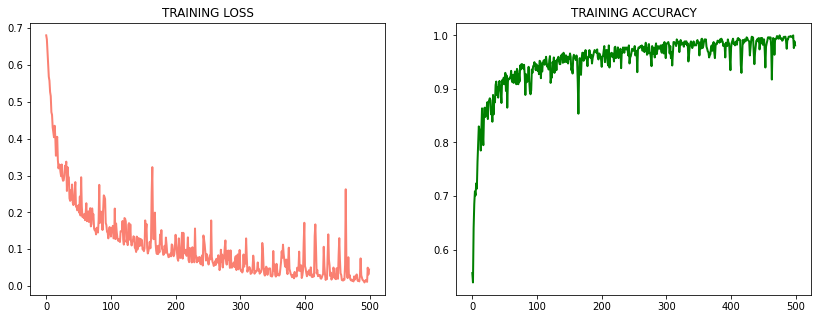

In [19]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].set_title('TRAINING LOSS');
ax[1].set_title('TRAINING ACCURACY');


ax[0].plot(history.history['loss'], color= 'salmon',lw=2);
ax[1].plot(history.history['accuracy'], color= 'green',lw=2);

In [20]:
#predict the validation data
predictions = model.predict_classes(bf_train_val)

- CONFUSION MATRIX

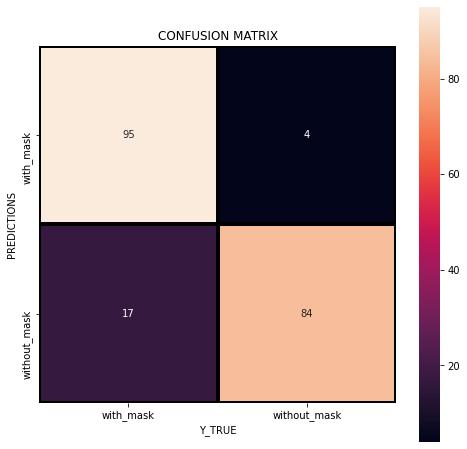

In [21]:
con_mat = confusion_matrix(y_val, predictions)

plt.figure(figsize=(8,8))
plt.title('CONFUSION MATRIX')

sns.heatmap(con_mat,
            yticklabels=['with_mask', 'without_mask'], 
            xticklabels=['with_mask', 'without_mask'],
            annot=True, linecolor='black', linewidths=4, square=True);

plt.xlabel('Y_TRUE'), plt.ylabel('PREDICTIONS');

In [22]:
from keras.models import load_model
import tensorflow.compat.v1 as tf
import os
tf.keras.backend.set_learning_phase(0) 
model = tf.keras.models.load_model('./best_model.h5')#加载h5模型
export_path = os.path.join(os.getcwd(), 'output' )
 
with tf.keras.backend.get_session() as sess:
    tf.saved_model.simple_save(
        sess,
        export_path,
        inputs={'input_image': model.input},
        outputs={t.name: t for t in model.outputs})

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


AssertionError: Export directory already exists, and isn't empty. Please choose a different export directory, or delete all the contents of the specified directory: /Users/admin/Downloads/RealTimeObjectDetection-main/output